# **03 - Data Cleaning**

## Objectives

* Evalutate any missing data levels and decide how to handle
* Clean data ready for feature engineering and ML development

## Inputs

* Raw Dataset: inputs/datasets/raw-heritage-housing

## Outputs

* Clean Train and Test sets saved under outputs/datasets/cleaned 

## Additional Comments




---

# Change working directory

* As the notebooks are stored in a subfolder, when running the notebook in the editor, the working directory will need to be adjusted.

The working directory will be changed from its current folder to its parent folder
* access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Project5-PredictiveAnalytics-HeritageHousing/jupyter_notebooks'

The parent of the current directory needs to be made the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


* Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Project5-PredictiveAnalytics-HeritageHousing'

<hr>

## Data Loading 

### Load Data

In [4]:
import pandas as pd
heritage_housing = pd.read_csv('./inputs/datasets/raw-heritage-housing/house-price-20211124T154130Z-001/house-price/house_prices_records.csv')
heritage_housing.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


## Data Exploration

The focus of data cleaning should start with some exploration of the data, we will begin by assessing missing data levels within the dataset. We will start by examining distribution levels and shapes of the variables with missing data

In [5]:
missing_data_variables = heritage_housing.columns[heritage_housing.isna().sum() > 0].to_list()
missing_data_variables

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [6]:
from pandas_profiling import ProfileReport
if missing_data_variables:
    report = ProfileReport(df=heritage_housing[missing_data_variables], minimal=True)
    report.to_notebook_iframe()
else:
    print('There are no variables with missing data')

/tmp/ipykernel_20987/1028722235.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Correlation & Predictive Power Score Analysis

Next we will analyse the correlation and predictive power score of the variables. We will use the custom code generated within the Churnometer walkthrough project, the functions generate scores for the correlation and PPS scores using the Pearson and Spearman methods, and also generates heatmaps for both methods.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
%matplotlib inline

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='jet', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='gist_rainbow', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Using these custom functions we can calculate the correlation levels and the predictive power score for our data

In [8]:
heritage_corr_pearson, heritage_corr_spearman, pps_matrix = CalculateCorrAndPPS(heritage_housing)


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



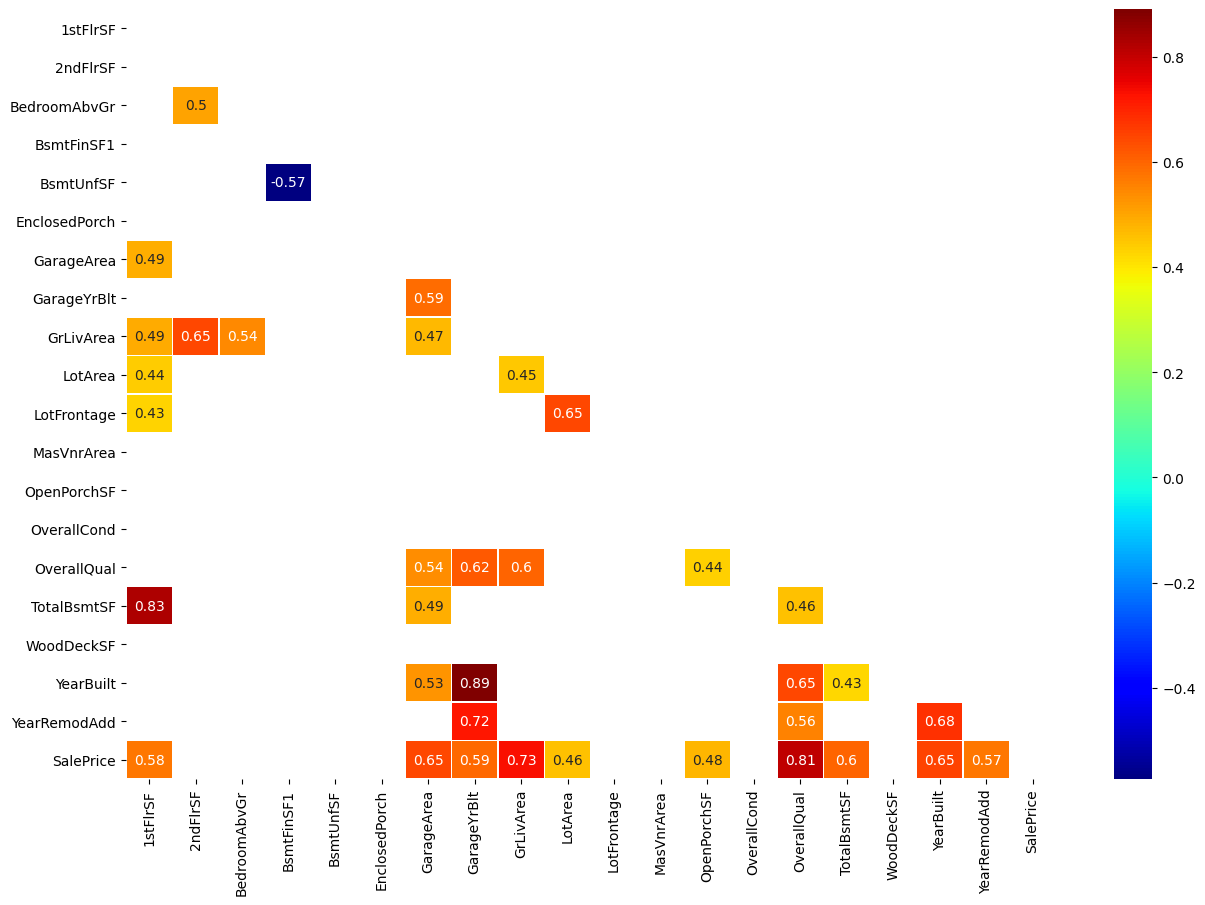



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



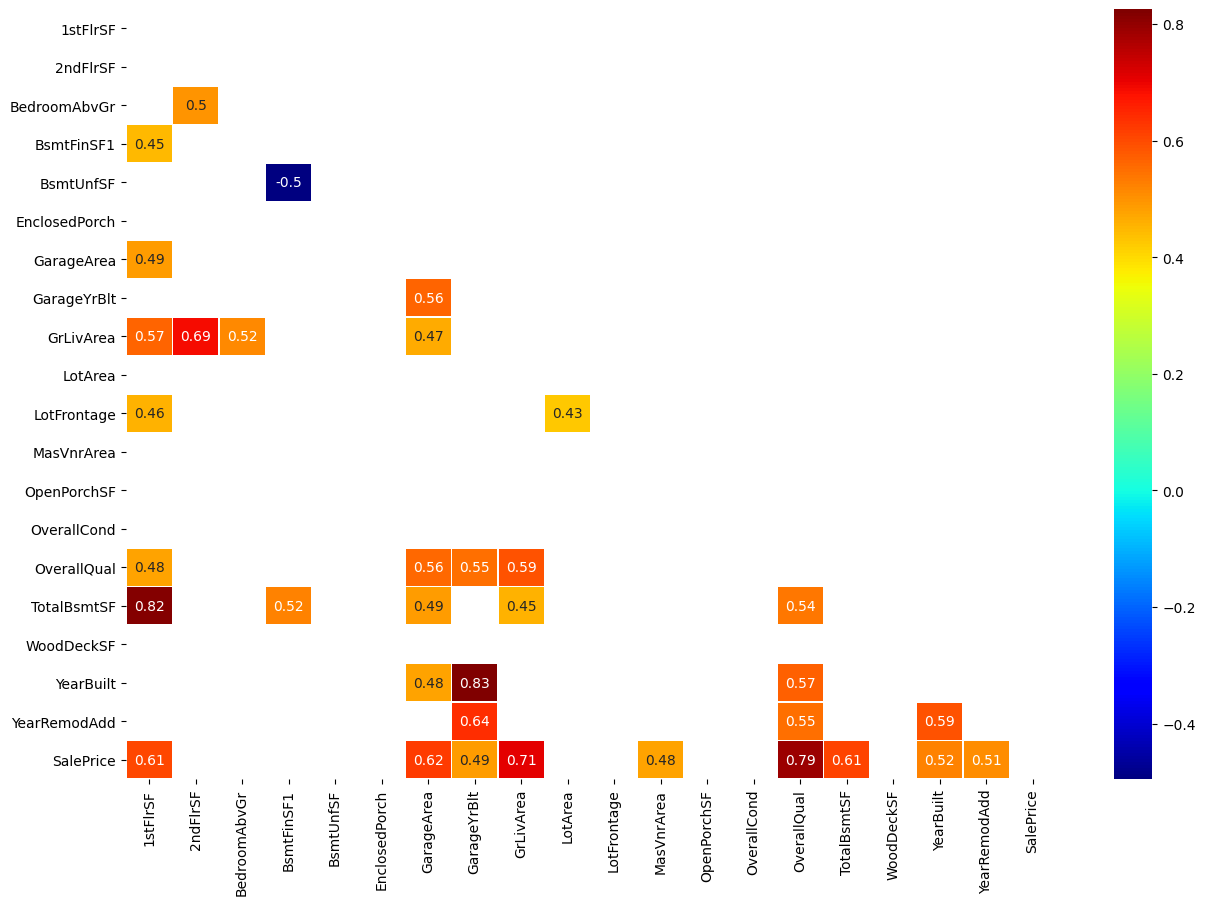



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



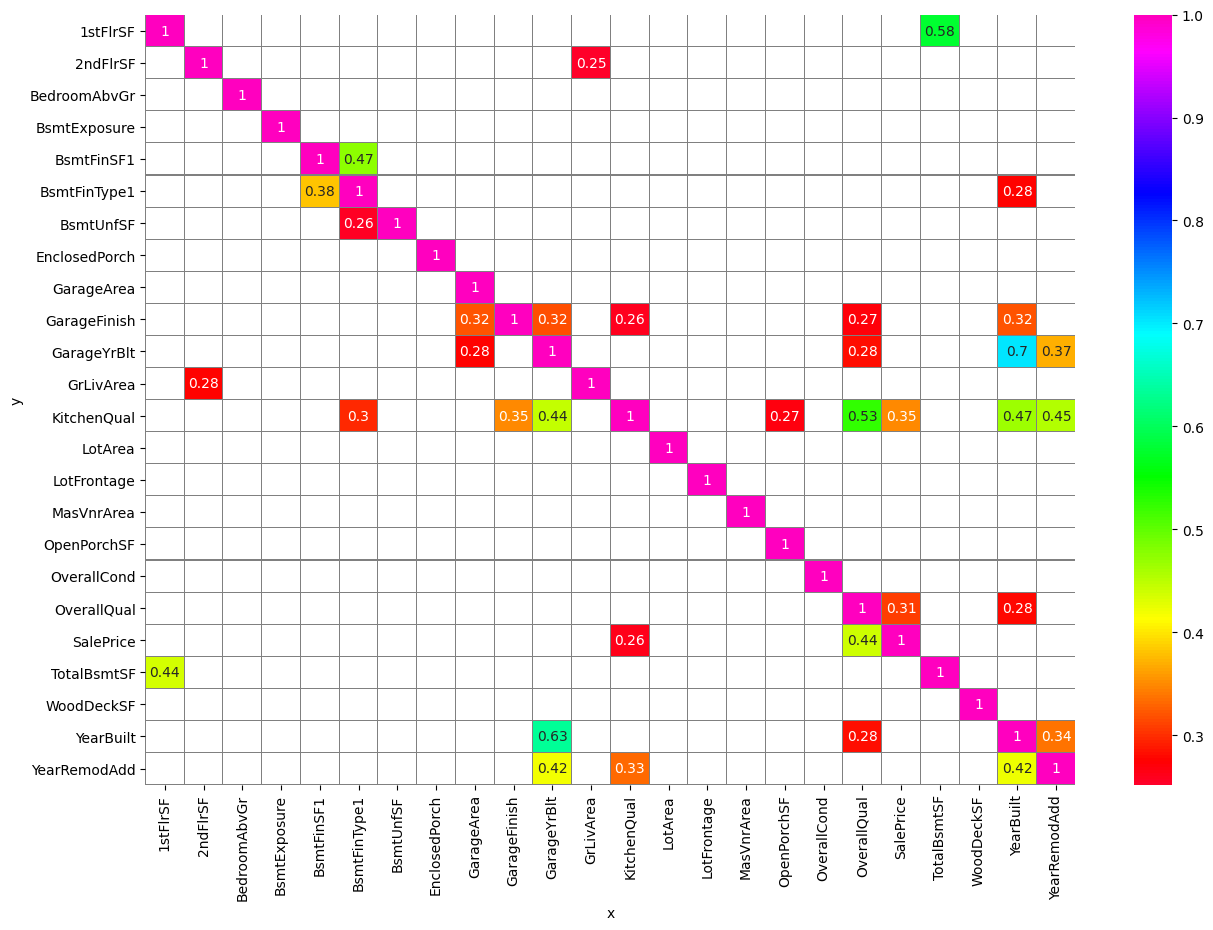

In [9]:
DisplayCorrAndPPS(df_corr_pearson = heritage_corr_pearson, 
                  df_corr_spearman = heritage_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.425, PPS_Threshold = 0.25,
                  figsize = (15, 10), font_annot=10)

---

## Data Cleaning

Evaluating missing data levels is our next step so we can address how to handle them, we use a custom function to check absolute levels and percentages for the missing data & their types.

In [10]:
def MissingDataLevels(df):
    absolute_missing = df.isnull().sum()
    percentage_missing = round(absolute_missing/len(df)*100, 2)
    missing_dataframe = (pd.DataFrame(
        data = {'Rows with missing values': absolute_missing,
                'Percentage of Data': percentage_missing,
                'Data Types': df.dtypes})
                .sort_values(by=['Percentage of Data'], ascending=False)
                .query("`Percentage of Data` > 0")
    )

    return missing_dataframe

Next we will run this function on our collected raw dataset. 

In [11]:
MissingDataLevels(heritage_housing)

,Rows with missing values,Percentage of Data,Data Types
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


### Missing Data Analysis

As many machine learning algorithms will fail when faced with missing values, we will investigate several potential methods to address these features that are missing and identify the best possible imputer solution to use. The table beneath shows our final decisions with a more detailed explanation below.

| Variable | Missing Value Row Count | % Total of Data | DTypes | Potential Imputer Approach |
| --- | --- | --- | --- | --- |
| EnclosedPorch | 1324 |  90.68 |  float64 | Arbitrary Number | 
| WoodDeckSF | 1305 | 89.38 | float64 | Arbitray Number |
| LotFrontage | 259 | 17.74 | float64 | Mean Median |
| GarageFinish | 162 | 11.10 | object | Categorical Variable |
| BsmtFinType1 | 114 | 7.81 | object | Categorical Variable | 
| BedroomAbvGr | 99 | 6.78 | float64 | Mean Median | 
| 2ndFlrSF | 86 | 5.89 | float64 | Arbitrary Number | 
| GarageYrBlt | 81 | 5.55 | float64 | Mean Median |
| MasVnrArea | 8 | 0.55 | float 64 | Arbitrary Number |

### Arbitrary Number Imputer

We can clearly see in our table that the two features that have the highest percentage of missing values are <code>EnclosedPorch</code> & <code>WoodDeckSF</code>. It is not unreasonable to assume that as they are both contain over 80% of missing data that we would drop the columns as we did during our study on <code>SalePrice</code>, however it is always as a last resort. 

When we examine the PandasProfiling report we can see that the majority of the available values for <code>EnclosedPorch</code>, <code>WoodDeckSF</code>, <code>2ndFlrSF</code>, <code>MasVnrArea</code> are 0 anyway. So it would make sense that we can replace the missing values of these Features with our arbitrary number of 0 without affecting the integrity of our data or performance of our ML model while being able to avoid dropping any of the data.

### Mean Median Imputer

Firstly we will examine the numerical features that would be unsuitable for using an arbitrary number to populate the missing values, we will start with <code>GarageYrBlt</code>. 

In [12]:
heritage_garages_missing = heritage_housing[heritage_housing['GarageYrBlt'].isna()]
heritage_garages_missing[['GarageArea', 'GarageFinish', 'GarageYrBlt']]

,GarageArea,GarageFinish,GarageYrBlt
39,0,None,NaN
48,0,None,NaN
78,0,None,NaN
88,0,None,NaN
89,0,None,NaN
...,...,...,...
1349,0,None,NaN
1407,0,None,NaN
1449,0,None,NaN
1450,0,None,NaN


We can see from examining the list that the high majority of missing values for this feature are strongly indicative that the house doesn't have a garage, so we can fill the missing values using MeanMedianImputer. We can see from the correlation level heatmaps that while <code>GarageYrBlt</code> is correlated with <code>SalePrice</code>, <code>GarageArea</code> is more positively correlated so that should take precedence when fitting the model.

Next we will examine <code>BedroomAbvGr</code>. As the number of bedrooms can have an effect on <code>SalePrice</code> it is prudent to fill the values also using the MeanMedianImputer to generate an average. It is worth noting that with more time and resources it could be possible to more accurately investigate the number of bedrooms based on other factors such as the size of the first and second floors, as an argument could be made that the larger the size of the house, the more likely it would be to have a higher number of bedrooms. 

The next feature we will look at is <code>LotFrontage</code>, it would be most prudent to use the average value to fill the data without affecting our ML performance severely as there is minimal correlation between this feature & our target <code>SalePrice</code>.

### Categorical Variable Imputer

Firstly when considering our two object data type features, we will look at the <code>GarageFinish</code>. As shown in our correlation study and heatmaps, there is minimal correlation between this feature and our target <code>SalePrice</code>. However unlike to our investigation into <code>GarageYrBlt</code> we can see when we examine the values that the other features are strongly indicative that the houses do have a garage.

In [15]:
heritage_grg_fin_missing = heritage_housing[heritage_housing['GarageFinish'].isna()]
heritage_grg_fin_missing[['GarageArea', 'GarageFinish', 'GarageYrBlt', 'BsmtUnfSF']]

,GarageArea,GarageFinish,GarageYrBlt,BsmtUnfSF
7,484,NaN,1973.0,216
12,352,NaN,1962.0,175
23,572,NaN,1976.0,200
27,772,NaN,2008.0,486
35,691,NaN,2004.0,1117
...,...,...,...,...
1401,398,NaN,2004.0,80
1415,660,NaN,2007.0,398
1438,923,NaN,1957.0,312
1442,812,NaN,2008.0,252


---

NOTE

* You may add as many sections as you want, as long as they support your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [13]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)


IndentationError: expected an indented block (2852421808.py, line 5)